In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping



In [2]:
#Use the prepared data and create a pivot table
aggLSTM = pd.read_parquet("Data/agg_table_new_zones8Bot.parquet")
pivot_df = aggLSTM.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0)
adj_matrix = pd.read_parquet("Data/neighbours_zones_8.parquet")
adj_matrix.index = adj_matrix.columns

In [3]:
adj_matrix.index = adj_matrix.index.astype(str)
adj_matrix.columns = adj_matrix.columns.astype(str)

In [4]:
original_area_columns = pivot_df.columns.tolist()

In [5]:
#Combine matrix with pivot
common_indices = list(set(original_area_columns) & set(adj_matrix.index) & set(adj_matrix.columns))
neighbor_df = adj_matrix.loc[common_indices, common_indices]


# Create a dictionary map based on neighbours
h3_indices_in_pivot = original_area_columns # Use the order
neighbor_map = {h3_index: [] for h3_index in h3_indices_in_pivot}

neighbor_df_indices = neighbor_df.index.tolist()

# Walk through of each area
for center_h3 in h3_indices_in_pivot:
    if center_h3 in neighbor_df_indices:
        # Find neighbours
        neighbors = neighbor_df.columns[neighbor_df.loc[center_h3] == 1].tolist()
        # Add neighbours 
        valid_neighbors = [nb for nb in neighbors if nb in h3_indices_in_pivot and nb != center_h3]
        neighbor_map[center_h3] = valid_neighbors


# Cumulate the orders of neighbours
pivot_df_with_neighbors = pivot_df.copy()
neighbor_sum_cols = []

for h3_index in original_area_columns:
    neighbor_feature_name = f"{h3_index}_neighbor_sum"
    neighbor_sum_cols.append(neighbor_feature_name)
    # Use neighbours of first mapping
    valid_neighbors = [neighbor for neighbor in neighbor_map.get(h3_index, []) if neighbor in pivot_df.columns]

    if valid_neighbors:
        pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
    else:
        pivot_df_with_neighbors[neighbor_feature_name] = 0.0


pivot_df = pivot_df_with_neighbors #The new data frame for going further


C:\Users\freud\AppData\Local\Temp\ipykernel_10164\1625745289.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_10164\1625745289.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df_with_neighbors[neighbor_feature_name] = pivot_df[valid_neighbors].sum(axis=1)
C:\Users\freud\AppData\Local\Temp\ipykernel_10164\1625745289.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [23]:
pivot_df = pivot_df.reset_index() # Make 'time_bin' a column again
pivot_df['hour'] = pivot_df['time_bin'].dt.hour
pivot_df['dayofweek'] = pivot_df['time_bin'].dt.dayofweek

# Cyclical features
pivot_df['hour_sin'] = np.sin(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['hour_cos'] = np.cos(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['day_sin'] = np.sin(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['day_cos'] = np.cos(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['is_weekend'] = pivot_df['dayofweek'].isin([5, 6]).astype(int) # Weekend feature

time_bins_original = pivot_df['time_bin'].copy() # Store original timestamps for later evaluation

# Define feature column lists
area_columns = original_area_columns # Target variables (Order Counts)
# neighbor_sum_cols was created in step 2
time_feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend']
n_areas = len(area_columns)
n_neighbor_features = len(neighbor_sum_cols)
n_time_features = len(time_feature_cols)

# Prepare DataFrame for scaling: order columns correctly
ordered_cols = area_columns + neighbor_sum_cols + time_feature_cols
pivot_df_for_scaling = pivot_df[ordered_cols] # Select and order columns

# Store column order for inverse transform
column_order_for_scaling = pivot_df_for_scaling.columns.tolist()

In [7]:
# Normalize the delivery counts using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pivot_df_for_scaling)

In [8]:
# Creates sequences X (time_steps, n_all_features) and targets y (n_target_features)
def create_lstm_dataset(data, time_steps=4, n_target_features=None):
    X, y = [], []
    # Data shape is (n_samples, n_all_features)
    # n_target_features is the number of columns we want to predict (area_columns)
    for i in range(len(data) - time_steps):
        # X: Sequence of the past 'time_steps' including all features
        X.append(data[i : i + time_steps, :]) # Append all columns for the sequence window

        # y: Target features (area_columns) at the next time step (i + time_steps)
        y.append(data[i + time_steps, :n_target_features]) # Append only the target columns

    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
# Generate Sequences and Split Data
time_steps = 4 # the window size for LSTM sequences

# the adjusted function, passing the number of target features
X, y = create_lstm_dataset(scaled_data, time_steps=time_steps, n_target_features=n_areas)

# Split into Training+Validation and Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False 
)

# Split Training+Validation into Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
     X_train_val, y_train_val, test_size=0.15, shuffle=False # Use 15% of the rest for validation
)

#Use time serires split for better validation
tscv = TimeSeriesSplit(n_splits=5) # Example: 5 folds
train_indices, val_indices = list(tscv.split(X_train_val))[-1] # Use the last split for a single validation set
X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]

# Get the number of features for the LSTM input layer
n_features = X_train.shape[2]

Creating LSTM dataset...
Splitting data (Train/Val/Test)...
Train shapes: X=(557, 4, 283), y=(557, 139)
Val shapes:   X=(111, 4, 283), y=(111, 139)
Test shapes:  X=(96, 4, 283), y=(96, 139)
Number of features per time step: 283


In [ ]:
# Build and Train LSTM Model
model = Sequential()
# Input shape is (time_steps, n_features) where n_features includes targets, neighbors, and time
model.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features)))
model.add(Dropout(0.2)) # Add dropout for regularization
# Dense layer outputs predictions for each target area (n_areas)
model.add(Dense(units=n_areas)) # Output dimension must match y_train.shape[1]
model.compile(optimizer='adam', loss='mse') # Using Adam optimizer and Mean Squared Error loss

model.summary() # Print model architecture

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50, # Set number of epochs
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping], # Use early stopping
                    verbose=1) # Show progress

print("Training complete.")

Building LSTM model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                66800     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 139)               7089      
                                                                 
Total params: 73,889
Trainable params: 73,889
Non-trainable params: 0
_________________________________________________________________
Training LSTM model...
Epoch 1/50
18/18 [==============================] - 2s 36ms/step - loss: 0.0316 - val_loss: 0.0212
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0183 - val_loss: 0.0145
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 

Final Test Loss (scaled): 0.009384638629853725


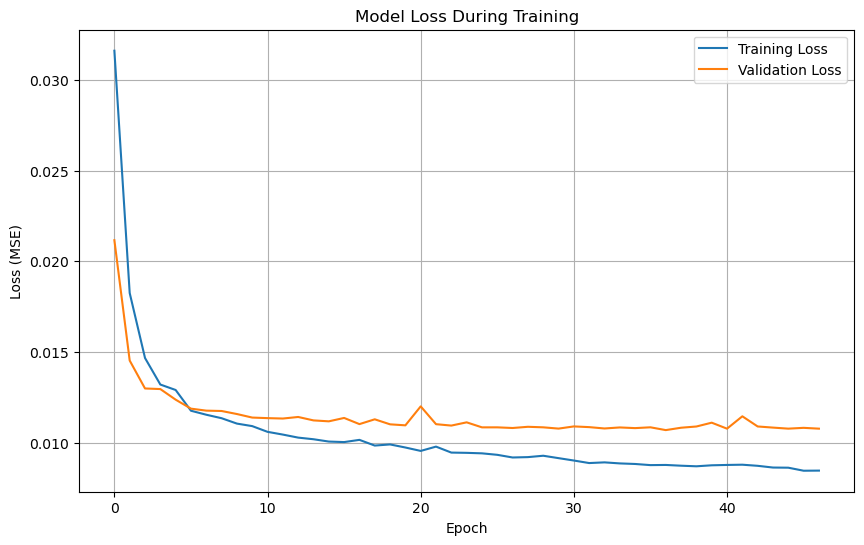

In [12]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss (scaled): {test_loss}")

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions_scaled = model.predict(X_test)

3/3 [==============================] - 0s 31ms/step


In [14]:
dummy_shape = (predictions_scaled.shape[0], scaled_data.shape[1])
predictions_dummy = np.zeros(dummy_shape)
predictions_dummy[:, :n_areas] = predictions_scaled
predictions_rescaled = scaler.inverse_transform(predictions_dummy)[:, :n_areas] # Extract only the rescaled target predictions

In [ ]:
y_test_dummy = np.zeros(dummy_shape)
y_test_dummy[:, :n_areas] = y_test # y_test already has shape (n_samples, n_areas)

# Inverse transform the actual test targets
y_test_rescaled = scaler.inverse_transform(y_test_dummy)[:, :n_areas] # Extract only the rescaled actual targets

# Ensure predictions are non-negative integers
predictions_rescaled = np.round(predictions_rescaled).astype(int)
predictions_rescaled = np.clip(predictions_rescaled, a_min=0, a_max=None)
y_test_rescaled = np.round(y_test_rescaled).astype(int) # Also round actual for fair comparison if needed
y_test_rescaled = np.clip(y_test_rescaled, a_min=0, a_max=None)


# Combine results for overall evaluation
y_tests_all_rescaled = y_test_rescaled.flatten()
y_preds_all_rescaled = predictions_rescaled.flatten()

# Basic evaluation metrics
n = len(y_tests_all_rescaled)
p = X_train.shape[1] * X_train.shape[2]

rmse = np.sqrt(mean_squared_error(y_tests_all_rescaled, y_preds_all_rescaled))
mae = mean_absolute_error(y_tests_all_rescaled, y_preds_all_rescaled)
r2 = r2_score(y_tests_all_rescaled, y_preds_all_rescaled)

# NRMSE
mean_abs_actual = np.mean(np.abs(y_tests_all_rescaled))
nrmse = rmse / mean_abs_actual * 100 if mean_abs_actual != 0 else np.nan

# MAPE
nonzero_indices = y_tests_all_rescaled != 0
mape = np.mean(np.abs((y_tests_all_rescaled[nonzero_indices] - y_preds_all_rescaled[nonzero_indices]) / y_tests_all_rescaled[nonzero_indices])) * 100 if np.any(nonzero_indices) else np.nan

# Adjusted R²
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

print(f"MAPE: {mape:.2f}%")
print(f"NRMSE: {nrmse:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Adjusted R²: {adj_r2:.2f}")

Calculating evaluation metrics on rescaled data...

--- Evaluation across all areas (LSTM with Neighbors) ---
MAPE: 47.39%
NRMSE: 67.26%
RMSE: 3.10
MAE: 1.35
R²: 0.93
Adjusted R²: 0.92


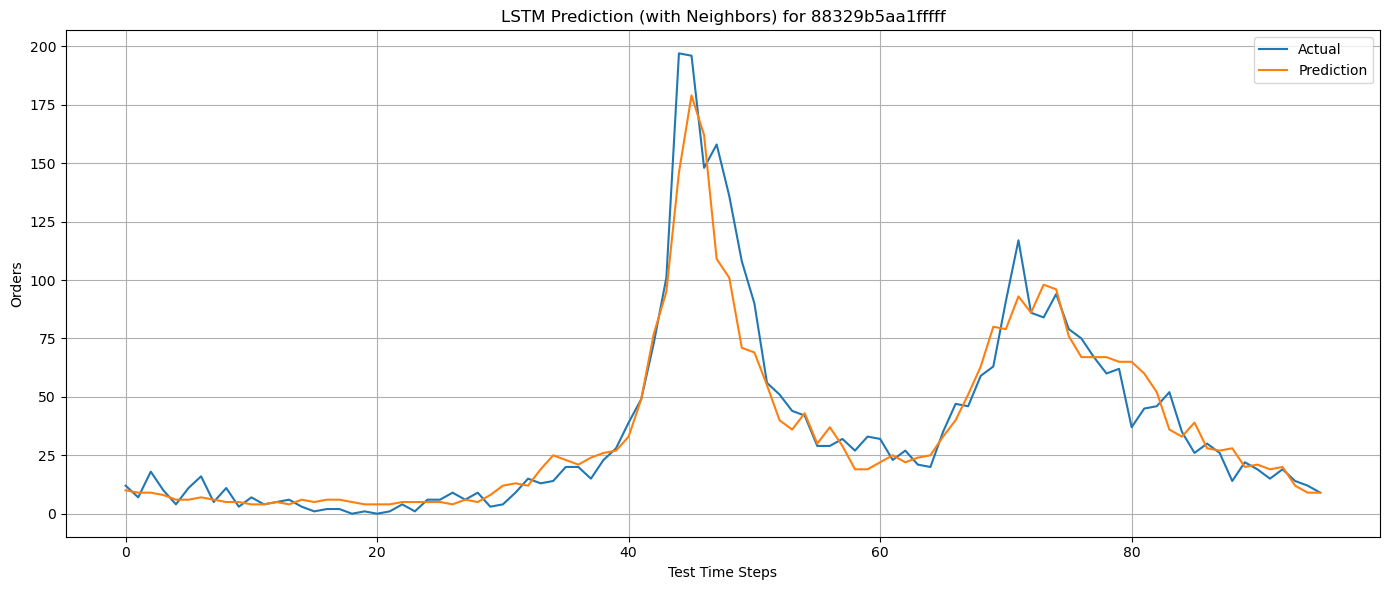

In [ ]:
example_area_plot = "88329b5aa1fffff" # Choose an area

example_index_plot = original_area_columns.index(example_area_plot)

plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:, example_index_plot], label='Actual')
plt.plot(predictions_rescaled[:, example_index_plot], label='Prediction')
plt.title(f'LSTM Prediction (with Neighbors) for {example_area_plot}')
plt.xlabel('Test Time Steps')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


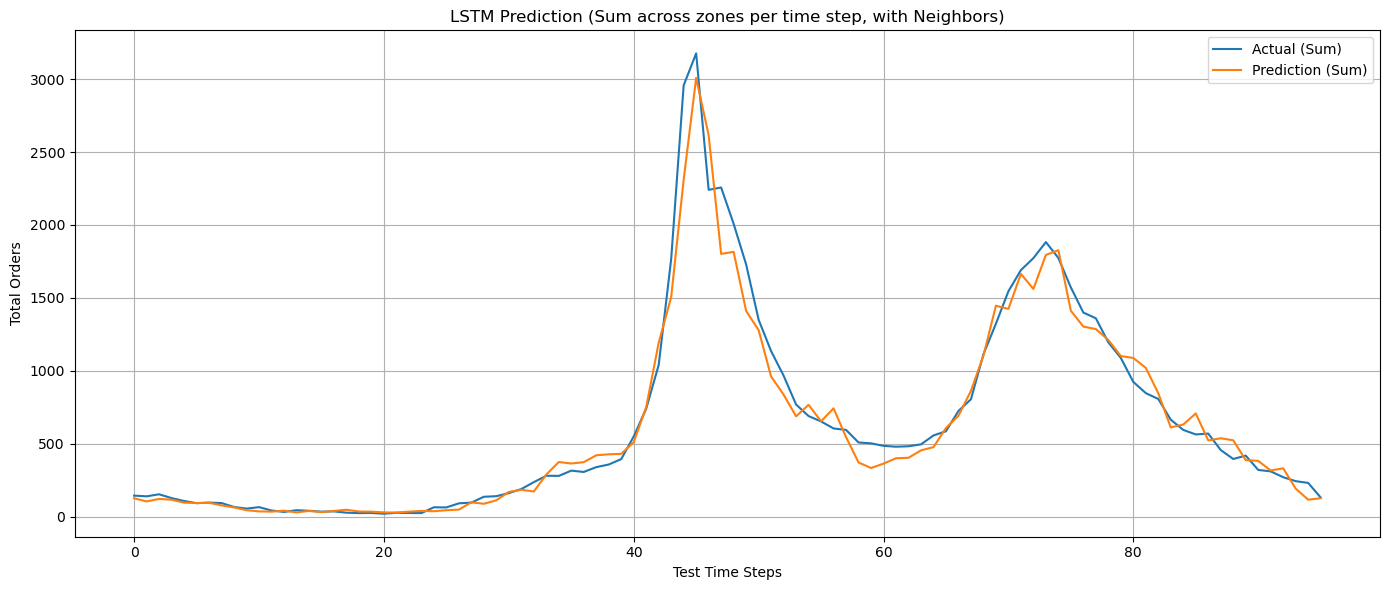

In [17]:
total_actual_per_step = np.sum(y_test_rescaled, axis=1)
total_predicted_per_step = np.sum(predictions_rescaled, axis=1)

plt.figure(figsize=(14, 6))
plt.plot(total_actual_per_step, label='Actual (Sum)')
plt.plot(total_predicted_per_step, label='Prediction (Sum)')
plt.title('LSTM Prediction (Sum across zones per time step, with Neighbors)')
plt.xlabel('Test Time Steps')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rmse_total = np.sqrt(mean_squared_error(total_actual_per_step, total_predicted_per_step))
mae_total = mean_absolute_error(total_actual_per_step, total_predicted_per_step)
r2_total = r2_score(total_actual_per_step, total_predicted_per_step)
mask_total = total_actual_per_step != 0
mape_total = np.mean(np.abs((total_actual_per_step[mask_total] - total_predicted_per_step[mask_total]) / total_actual_per_step[mask_total])) * 100 if np.any(mask_total) else np.nan

print(f"RMSE (Sum): {rmse_total:.2f}")
print(f"MAE  (Sum): {mae_total:.2f}")
print(f"R²   (Sum): {r2_total:.2f}")
print(f"MAPE (Sum): {mape_total:.2f}%")


--- Metrics for Sum across areas per time step (LSTM with Neighbors) ---
RMSE (Sum): 125.11
MAE  (Sum): 75.80
R²   (Sum): 0.97
MAPE (Sum): 16.44%


In [24]:
# Naive (Last Week) Model 

# Calculate the interval duration (assuming 15 minutes based on 4 steps per hour)
interval_minutes = 15 # Adjust if your time bins are different
steps_per_hour = 60 // interval_minutes
steps_per_day = 24 * steps_per_hour
steps_per_week = 7 * steps_per_day

# --- ADDED CALCULATION HERE ---
# Calculate the start index of the test data within the *original, unsequenced* data
# len(X_train) + len(X_val) is the number of samples in Train+Val Sets
# time_steps must be added because create_lstm_dataset cuts off the beginning
test_start_original_index = len(X_train) + len(X_val) + time_steps
# --- END ADDED CALCULATION ---

# Calculate the start index for the comparison data (one week before)
comparison_idx_start = test_start_original_index - steps_per_week

# Number of test samples
num_test_samples = len(y_test) # Or X_test.shape[0]

In [25]:
# Get the actual unscaled values from one week before from the *ordered dataframe used for scaling*
# Slice has shape (num_test_samples, n_total_features)
y_lastweek_orig_all_features = pivot_df_for_scaling.iloc[comparison_idx_start : comparison_idx_start + num_test_samples].values

# Extract only the target columns (order counts) for the naive prediction
# Shape: (num_test_samples, n_areas)
predicted_lastweek = y_lastweek_orig_all_features[:, :n_areas]
predicted_lastweek = np.round(predicted_lastweek).astype(int) # Ensure integer counts
predicted_lastweek = np.clip(predicted_lastweek, a_min=0, a_max=None) # Ensure non-negative

# 'actual' is the correctly rescaled y_test from the LSTM evaluation
actual = y_test_rescaled # Shape: (num_test_samples, n_areas)
predicted_lstm = predictions_rescaled # Renamed for clarity in plot

In [26]:
# Flatten arrays for overall metrics calculation
actual_flat = actual.flatten()
predicted_lastweek_flat = predicted_lastweek.flatten()

# --- Calculate Naive Metrics ---
rmse_lw = np.sqrt(mean_squared_error(actual_flat, predicted_lastweek_flat))
mae_lw = mean_absolute_error(actual_flat, predicted_lastweek_flat)
r2_lw = r2_score(actual_flat, predicted_lastweek_flat) # R² calculated on flattened data

# Use the same mean_abs_actual calculated before for LSTM NRMSE for consistency
mean_abs_actual = np.mean(np.abs(y_tests_all_rescaled)) # Recalculate just in case
nrmse_lw = rmse_lw / mean_abs_actual * 100 if mean_abs_actual != 0 else np.nan

# MAPE calculation
nonzero_indices_lw = actual_flat != 0
mape_lw = np.mean(np.abs((actual_flat[nonzero_indices_lw] - predicted_lastweek_flat[nonzero_indices_lw]) / actual_flat[nonzero_indices_lw])) * 100 if np.any(nonzero_indices_lw) else np.nan

# Adjusted R²: Use R² from LSTM evaluation for comparison basis, not r2_lw
# 'n' and 'p' are from the LSTM evaluation context
adj_r2_lw_comparison = 1 - (1 - r2_lw) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

print("\n--- Naive (Last Week) Evaluation Results ---")
print(f"Naive MAPE: {mape_lw:.2f}%")
print(f"Naive NRMSE: {nrmse_lw:.2f}%")
print(f"Naive RMSE: {rmse_lw:.2f}")
print(f"Naive MAE:  {mae_lw:.2f}")
print(f"Naive R²: {r2_lw:.2f}")
print(f"Naive Adjusted R² (for comparison context): {adj_r2_lw_comparison:.2f}") # Less meaningful for naive


--- Naive (Last Week) Evaluation Results ---
Naive MAPE: 60.00%
Naive NRMSE: 70.14%
Naive RMSE: 3.23
Naive MAE:  1.55
Naive R²: 0.92
Naive Adjusted R² (for comparison context): 0.91


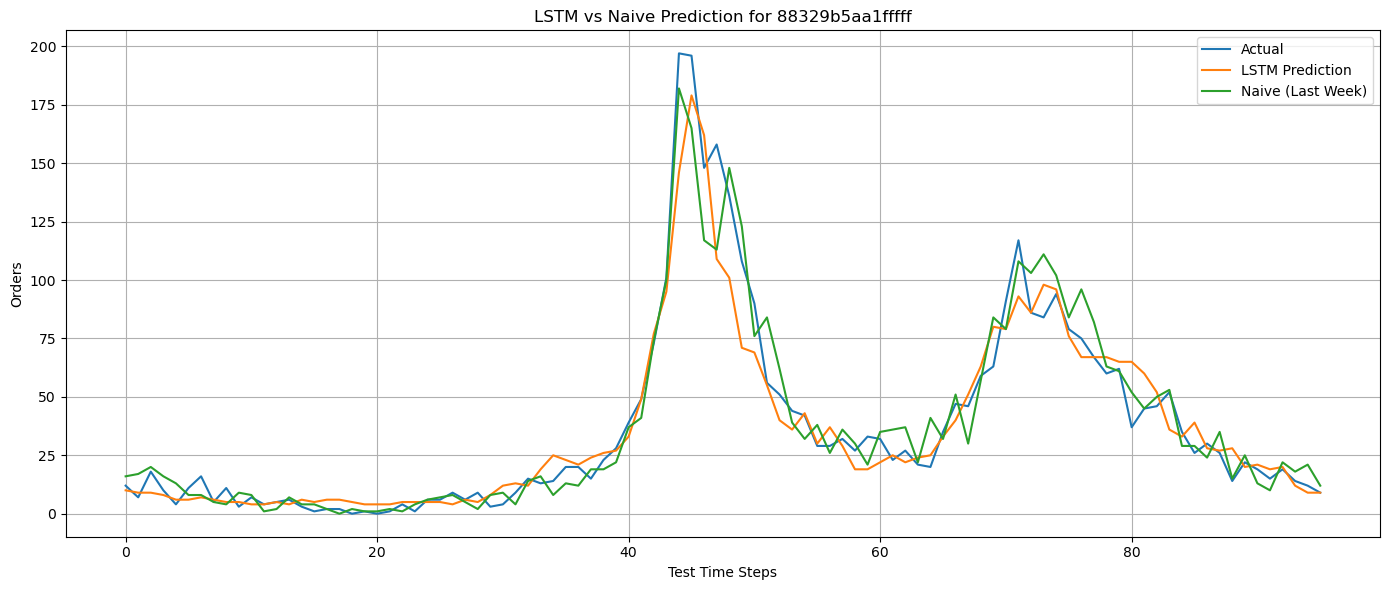

In [27]:
example_index_plot = original_area_columns.index(example_area_plot)
plt.figure(figsize=(14, 6))
plt.plot(actual[:, example_index_plot], label='Actual')
plt.plot(predicted_lstm[:, example_index_plot], label='LSTM Prediction')
plt.plot(predicted_lastweek[:, example_index_plot], label='Naive (Last Week)')
plt.title(f'LSTM vs Naive Prediction for {example_area_plot}')
plt.xlabel('Test Time Steps')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# # Loading of other models
# prognose_arima = np.load('prognose_arima.npy')
# prognose_RF = np.load('prognose_RF.npy')
# prognose_XGB = np.load('prognose_XGB.npy')
# prognose_GCN_LSTM = np.load('prognose_GCN_LSTM.npy')



In [ ]:
# import os
# example_area = "88329b5aa1fffff"  # change the area to observe
# example_index = pivot_df.columns.get_loc(example_area)
# plot_dir = "graphics"
# os.makedirs(plot_dir, exist_ok=True)

# plt.figure(figsize=(15, 8))
# plt.plot(actual[:, example_index], label="Actual Deliveries")
# plt.plot(predicted_lstm[:, example_index], label="LSTM Prediction")
# plt.plot(predicted_lastweek[:, example_index], label="Naive (Last Week Same Time)")
# plt.plot(prognose_arima, label="Arima Prediction")
# plt.plot(prognose_RF, label="Random Forest Prediction")
# plt.plot(prognose_XGB, label="XGBoost Prediction")

# plt.title("Models Prediction vs Actual Orders in example Hexagon")
# plt.xlabel("Time Step")
# plt.ylabel("Delivery Count")
# plt.legend()
# plt.grid(True)

# policy_plot_filename = os.path.join(plot_dir, f"Modelpredcomparison.svg")
# plt.savefig(policy_plot_filename, format='svg', bbox_inches='tight')
# plt.show()

